In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
fifa17_raw_data = pd.read_csv("data/FIFA17_official_data.csv")
fifa18_raw_data = pd.read_csv("data/FIFA18_official_data.csv")
fifa19_raw_data = pd.read_csv("data/FIFA19_official_data.csv")
fifa20_raw_data = pd.read_csv("data/FIFA20_official_data.csv")
fifa21_raw_data = pd.read_csv("data/FIFA21_official_data.csv")

old_raw_data = pd.concat([fifa17_raw_data, fifa18_raw_data, fifa19_raw_data, fifa20_raw_data, fifa21_raw_data], ignore_index=True)
old_raw_data.head(50)

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Best Position,Best Overall Rating,Release Clause,DefensiveAwareness
0,176580,L. Suárez,29,https://cdn.sofifa.com/players/176/580/17_60.png,Uruguay,https://cdn.sofifa.com/flags/uy.png,92,92,FC Barcelona,https://cdn.sofifa.com/teams/241/light_30.png,...,38.0,27.0,25.0,31.0,33.0,37.0,ST,88.0,NaN,NaN
1,178518,R. Nainggolan,28,https://cdn.sofifa.com/players/178/518/17_60.png,Belgium,https://cdn.sofifa.com/flags/be.png,86,86,Roma,https://cdn.sofifa.com/teams/52/light_30.png,...,88.0,11.0,11.0,14.0,8.0,11.0,CDM,84.0,NaN,NaN
2,181872,A. Vidal,29,https://cdn.sofifa.com/players/181/872/17_60.png,Chile,https://cdn.sofifa.com/flags/cl.png,87,87,FC Bayern München,https://cdn.sofifa.com/teams/21/light_30.png,...,84.0,4.0,2.0,4.0,2.0,4.0,CDM,85.0,NaN,NaN
3,197445,D. Alaba,24,https://cdn.sofifa.com/players/197/445/17_60.png,Austria,https://cdn.sofifa.com/flags/at.png,86,89,FC Bayern München,https://cdn.sofifa.com/teams/21/light_30.png,...,83.0,5.0,7.0,14.0,15.0,9.0,LB,84.0,NaN,NaN
4,195864,P. Pogba,23,https://cdn.sofifa.com/players/195/864/17_60.png,France,https://cdn.sofifa.com/flags/fr.png,88,94,Manchester United,https://cdn.sofifa.com/teams/11/light_30.png,...,73.0,5.0,6.0,2.0,4.0,3.0,CAM,85.0,NaN,NaN
5,173731,G. Bale,26,https://cdn.sofifa.com/players/173/731/17_60.png,Wales,https://cdn.sofifa.com/flags/gb-wls.png,90,90,Real Madrid,https://cdn.sofifa.com/teams/243/light_30.png,...,52.0,15.0,15.0,11.0,5.0,6.0,ST,88.0,NaN,NaN
6,203551,A. Florenzi,25,https://cdn.sofifa.com/players/203/551/17_60.png,Italy,https://cdn.sofifa.com/flags/it.png,82,85,Roma,https://cdn.sofifa.com/teams/52/light_30.png,...,77.0,9.0,8.0,10.0,11.0,10.0,RB,81.0,NaN,NaN
7,163631,L. Baines,31,https://cdn.sofifa.com/players/163/631/17_60.png,England,https://cdn.sofifa.com/flags/gb-eng.png,83,83,Everton,https://cdn.sofifa.com/teams/7/light_30.png,...,82.0,8.0,15.0,10.0,13.0,12.0,LWB,81.0,NaN,NaN
8,177003,L. Modrić,30,https://cdn.sofifa.com/players/177/003/17_60.png,Croatia,https://cdn.sofifa.com/flags/hr.png,89,89,Real Madrid,https://cdn.sofifa.com/teams/243/light_30.png,...,73.0,13.0,9.0,7.0,14.0,9.0,CM,86.0,NaN,NaN
9,20801,Cristiano Ronaldo,31,https://cdn.sofifa.com/players/020/801/17_60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,94,94,Real Madrid,https://cdn.sofifa.com/teams/243/light_30.png,...,23.0,7.0,11.0,15.0,14.0,11.0,ST,91.0,NaN,NaN


In [132]:
old_raw_data["Position"] = old_raw_data["Position"].str.extract(r'>\s*([^<]+)')

old_raw_data = old_raw_data.drop(old_raw_data[old_raw_data["Position"] == "GK"].index)
old_raw_data = old_raw_data.drop(old_raw_data[old_raw_data["Position"] == "SUB"].index)
old_raw_data = old_raw_data.drop(old_raw_data[old_raw_data["Position"] == "RES"].index)
old_raw_data = old_raw_data.drop(["Photo", "Flag", "Club Logo", "Special", "International Reputation", "Body Type", "Real Face", "Joined",
                                  "Loaned From","Contract Valid Until", "Release Clause", "Best Position", "Best Overall Rating", "Potential",
                                  "ID", "Name", "Nationality", "Club", "Value", "Wage", "Preferred Foot", "Weak Foot", "Skill Moves",
                                  "Work Rate", "Jersey Number", "Height", "Weight", "Age", "DefensiveAwareness"],
                                 axis=1, inplace=False)

old_raw_data.dropna(inplace=True)
old_raw_data.shape

,Overall,Position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,92,ST,77.0,94.0,77.0,83.0,88.0,86.0,86.0,84.0,...,85.0,83.0,30.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0
1,86,LF,73.0,76.0,59.0,84.0,75.0,80.0,73.0,68.0,...,63.0,85.0,78.0,85.0,88.0,11.0,11.0,14.0,8.0,11.0
2,87,LDM,76.0,77.0,81.0,84.0,78.0,76.0,76.0,68.0,...,84.0,86.0,76.0,89.0,84.0,4.0,2.0,4.0,2.0,4.0
3,86,LB,82.0,63.0,75.0,83.0,68.0,79.0,78.0,83.0,...,80.0,79.0,81.0,83.0,83.0,5.0,7.0,14.0,15.0,9.0
4,88,LDM,78.0,71.0,73.0,85.0,84.0,89.0,84.0,82.0,...,76.0,83.0,68.0,73.0,73.0,5.0,6.0,2.0,4.0,3.0
5,90,RW,87.0,87.0,86.0,86.0,76.0,89.0,86.0,85.0,...,76.0,85.0,51.0,55.0,52.0,15.0,15.0,11.0,5.0,6.0
7,83,LB,88.0,70.0,74.0,81.0,63.0,78.0,81.0,82.0,...,90.0,81.0,81.0,82.0,82.0,8.0,15.0,10.0,13.0,12.0
8,89,RCM,78.0,71.0,55.0,92.0,74.0,86.0,79.0,77.0,...,80.0,76.0,66.0,80.0,73.0,13.0,9.0,7.0,14.0,9.0
9,94,LW,84.0,93.0,85.0,83.0,88.0,92.0,81.0,76.0,...,85.0,86.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
11,81,RB,85.0,69.0,60.0,85.0,72.0,72.0,86.0,83.0,...,84.0,81.0,78.0,78.0,77.0,10.0,10.0,6.0,6.0,12.0


In [133]:
position_mapping = {
    'Defender': ['LB', 'LCB', 'LWB', 'RB', 'RCB', 'RWB', 'CB'],
    'Midfielder': ['CAM', 'CDM', 'CM', 'LAM', 'LCM', 'LDM', 'LM', 'RAM', 'RCM', 'RDM', 'RM'],
    'Striker': ['CF', 'LF', 'LS', 'RF', 'RS', 'ST', 'RW', 'LW']
}

old_raw_data["Position"] = old_raw_data["Position"].map(
    {pos: category for category, positions in position_mapping.items() for pos in positions})

,Overall,Position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,92,Striker,77.0,94.0,77.0,83.0,88.0,86.0,86.0,84.0,...,85.0,83.0,30.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0
1,86,Striker,73.0,76.0,59.0,84.0,75.0,80.0,73.0,68.0,...,63.0,85.0,78.0,85.0,88.0,11.0,11.0,14.0,8.0,11.0
2,87,Midfielder,76.0,77.0,81.0,84.0,78.0,76.0,76.0,68.0,...,84.0,86.0,76.0,89.0,84.0,4.0,2.0,4.0,2.0,4.0
3,86,Defender,82.0,63.0,75.0,83.0,68.0,79.0,78.0,83.0,...,80.0,79.0,81.0,83.0,83.0,5.0,7.0,14.0,15.0,9.0
4,88,Midfielder,78.0,71.0,73.0,85.0,84.0,89.0,84.0,82.0,...,76.0,83.0,68.0,73.0,73.0,5.0,6.0,2.0,4.0,3.0
5,90,Striker,87.0,87.0,86.0,86.0,76.0,89.0,86.0,85.0,...,76.0,85.0,51.0,55.0,52.0,15.0,15.0,11.0,5.0,6.0
7,83,Defender,88.0,70.0,74.0,81.0,63.0,78.0,81.0,82.0,...,90.0,81.0,81.0,82.0,82.0,8.0,15.0,10.0,13.0,12.0
8,89,Midfielder,78.0,71.0,55.0,92.0,74.0,86.0,79.0,77.0,...,80.0,76.0,66.0,80.0,73.0,13.0,9.0,7.0,14.0,9.0
9,94,Striker,84.0,93.0,85.0,83.0,88.0,92.0,81.0,76.0,...,85.0,86.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
11,81,Defender,85.0,69.0,60.0,85.0,72.0,72.0,86.0,83.0,...,84.0,81.0,78.0,78.0,77.0,10.0,10.0,6.0,6.0,12.0


In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

X = old_raw_data.drop("Position", axis=1)
y = old_raw_data["Position"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [136]:
y_pred = rfc.predict(X_test)

rfc_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {rfc_accuracy: .2f}")

print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy:  0.88
Classification report:
              precision    recall  f1-score   support

    Defender       0.91      0.94      0.93      1535
  Midfielder       0.85      0.87      0.86      1700
     Striker       0.86      0.75      0.80       710

    accuracy                           0.88      3945
   macro avg       0.87      0.85      0.86      3945
weighted avg       0.87      0.88      0.87      3945


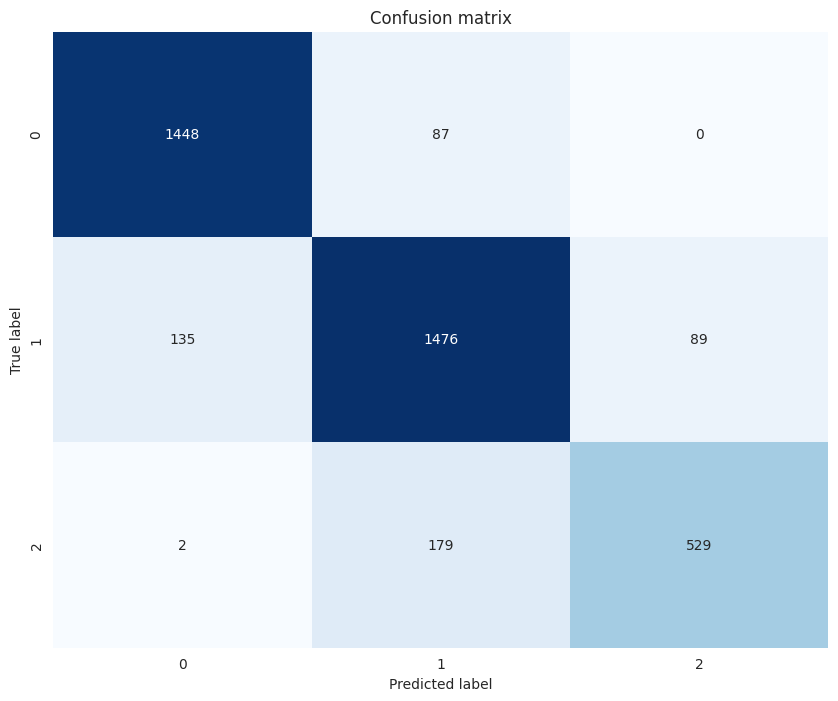

In [140]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.show();